In [1]:
#####Joint Dynamic Poisson Factrization#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
from datetime import datetime
from datetime import timedelta
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

In [2]:
#連続した日付を取得する関数
def daterange(_start, _end):
    for n in range((_end - _start).days):
        yield _start + timedelta(n)
        
#切断ポアソン分布を生成する関数
def rtpois(mu, a, b, n):
    FA = scipy.stats.poisson.cdf(a, mu)
    FB = scipy.stats.poisson.cdf(b, mu)
    return np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")

##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
####シミュレーションデータを作成####
##日付データを作成
#対象期間の日付と曜日情報を出力
start = datetime.strptime('2014-01-01', '%Y-%m-%d')
end   = datetime.strptime('2019-09-30', '%Y-%m-%d')
get_date = np.array([])
day_of_week = np.array([], dtype="int")
for day in daterange(start, end):
    get_date = np.append(get_date, day)
    day_of_week = np.append(day_of_week, day.weekday())
    
#日付を定義
index_week = np.array(np.where(day_of_week < 5)[0], dtype="int")
Timestamp = pd.Series(get_date).iloc[index_week]
date = pd.DataFrame({"date": Timestamp.astype("U")})
date_df = pd.merge(date, pd.DataFrame({"date": np.unique(date), "date_id": np.arange(date.shape[0])}), on="date", how="inner")
year = pd.DataFrame({"year": Timestamp.astype("U").str[:4]})
unique_year = np.unique(year)
year_df = pd.merge(year, pd.DataFrame({"year": unique_year, "year_id": np.arange(unique_year.shape[0])}), on="year", how="inner")
month = pd.DataFrame({"month": Timestamp.astype("U").str[5:7]})
unique_month = np.unique(month)
month_df = pd.merge(month, pd.DataFrame({"month": unique_month, "month_id": np.arange(unique_month.shape[0])}), on="month", how="inner")

#週を定義
new_week = day_of_week[index_week]
index = np.array(np.where((new_week-4)==0)[0], dtype="int")
week_n = index.shape[0]
week = np.repeat(0, new_week.shape[0])
for i in range(week_n):
    if i==0:
        get = np.arange(0, index[i]+1)
        week[get] = np.repeat(i, get.shape[0])
    else:
        get = np.arange(index[i-1]+1, index[i]+1)
        week[get] = np.repeat(i, get.shape[0])
        
#データフレームを作成
calendar_df = pd.concat((date_df, year_df, month_df, pd.DataFrame({"week_id": week})), axis=1)
date = np.array(calendar_df["date_id"], dtype="int")
year = np.array(calendar_df["year_id"], dtype="int")
month = np.array(calendar_df["month_id"], dtype="int")
week = np.array(calendar_df["week_id"], dtype="int")

In [4]:
##ニュースデータとグラフデータの生成
#データの定義
k = 10   
item = 350
element = 300
trend1 = 5
trend2 = 2
days = np.unique(date).shape[0]
years = np.unique(year).shape[0]
months = np.unique(month).shape[0]
weeks = np.unique(week).shape[0]
Lambda1 = np.random.gamma(70.0, 1/0.5, days)
Lambda2 = np.random.gamma(30.0, 1/0.25, item+1)
n1 = np.random.poisson(Lambda1, days)
n2 = np.random.poisson(Lambda2, item+1)
N1 = np.sum(n1)
N2 = np.sum(n2)
k_vec = np.repeat(1.0, k)

In [5]:
##idとインデックスを定義
#idの定義
date_id = np.repeat(date, n1)
year_id = np.repeat(year, n1)
month_id = np.repeat(month, n1)
week_id = np.repeat(week, n1)
item_id21 = np.repeat(np.arange(item+1), n2)

#インデックスを定義
date_list = [i for i in range(days)]
year_list = [i for i in range(years)]
month_list = [i for i in range(months)]
week_list = [i for i in range(weeks)]
item_list21 = [i for i in range(item+1)]
item_n21 = np.repeat(0, item+1)
for i in range(days):
    date_list[i] = np.array(np.where(date_id==i)[0], dtype="int")
for i in range(years):
    year_list[i] = np.array(np.where(year_id==i)[0], dtype="int")
for i in range(months):
    month_list[i] = np.array(np.where(month_id==i)[0], dtype="int")
for i in range(weeks):
    week_list[i] = np.array(np.where(week_id==i)[0], dtype="int")
for i in range(item+1):
    item_list21[i] = np.array(np.where(item_id21==i)[0], dtype="int")
    item_n21[i] = item_list21[i].shape[0]

In [6]:
##センチメントの状態の推移を生成
#モデルパラメータの定義
state = 5
S1 = np.array([0.05, 0.15, 0.6, 0.15, 0.05])
S2 = np.array([[0.8389, 0.15, 0.01, 0.001, 0.0001],
               [0.15, 0.8089, 0.03, 0.001, 0.0001],
               [0.01, 0.02, 0.95, 0.02, 0.01],
               [0.0001, 0.001, 0.03, 0.8089, 0.15],
               [0.0001, 0.001, 0.01, 0.15, 0.8389]])

#状態推移を生成
s = np.repeat(0, weeks)
for i in range(weeks):
    if i==0:
        s[i] = np.argmax(np.random.multinomial(1, S1, 1))
    else:
        s[i] = np.argmax(np.random.multinomial(1, S2[s[i-1], ], 1))

#回帰行列を生成
scale = 1.5
beta_positive = np.abs(np.random.normal(0.0, 0.5, k))
beta_neutral = np.abs(np.random.normal(0.0, 0.25, k))
beta_negative = np.abs(np.random.normal(0.0, 0.5, k))
beta = np.vstack((scale*beta_positive, beta_positive, beta_neutral, beta_negative, scale*beta_negative))
        
#ニュースデータのtrendを生成
Pi = np.array([[0.3, 0.15, 0.3, 0.15, 0.1],
               [0.25, 0.15, 0.25, 0.15, 0.2],
               [0.2, 0.2, 0.2, 0.2, 0.2],
               [0.15, 0.25, 0.15, 0.25, 0.2],
               [0.15, 0.3, 0.15, 0.3, 0.1]])
trend_id1 = rmnom(Pi[s[week_id], ], N1, state, 0)

#インデックスを定義
trend_list11 = [i for i in range(trend1)]
trend_list12 = [i for i in range(trend1)]
for i in range(trend1):
    temp_list = [j for j in range(weeks)]
    trend_list11[i] = np.array(np.where(trend_id1==i)[0], dtype="int")
    for j in range(weeks):
        temp_list[j] = np.array(np.where((week_id==j) & (trend_id1==i))[0], dtype="int")
    trend_list12[i] = temp_list

In [7]:
##アイテムとエレメントの割当を生成
#トピック割当を生成
topic = 30
phi_item = np.random.dirichlet(np.repeat(0.1, item+1), topic)
phi_element = np.random.dirichlet(np.repeat(0.1, element+1), topic)
phi_trend = np.random.beta(0.5, 0.5, topic)
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), days)
theta_item = np.random.dirichlet(np.repeat(0.2, topic), days)
z1 = np.array(rmnom(theta_topic[date_id, ], N1, topic, 0), dtype="int16")
z2 = np.array(rmnom(theta_item[item_id21, ], N2, topic, 0), dtype="int16")

#多項分布からニュースデータの要因を生成
item_id1 = np.repeat(0, N1)
element_id1 = np.repeat(0, N1)
element_id21 = np.repeat(0, N2)
element_id22 = np.repeat(0, N2)
for i in range(days):
    item_id1[date_list[i]] = rmnom(phi_item[z1[date_list[i]], ], n1[i], item, 0)
    element_id1[date_list[i]] = rmnom(phi_element[z1[date_list[i]], ], n1[i], element, 0)
    
#多項分布からグラフデータの要因を生成
item_id22 = np.repeat(0, N2)
item_n22 = np.repeat(0, item+1) 
element_id21 = np.repeat(0, N2)
element_id22 = np.repeat(0, N2)
trend_id2 = np.repeat(0, N2)
item_list22 = [i for i in range(item+1)]
for i in range(item+1):
    item_id22[item_list21[i]] = rmnom(phi_item[z2[item_list21[i]], ], item_n21[i], item, 0)
for i in range(item+1):
    item_list22[i] = np.array(np.where(item_id22==i)[0], dtype="int")
    item_n22[i] = item_list22[i].shape[0]
    element_id21[item_list21[i]] = rmnom(phi_element[z2[item_list21[i]], ], item_n21[i], element, 0)
    element_id22[item_list22[i]] = rmnom(phi_element[z2[item_list22[i]], ], item_n22[i], element, 0)
    trend_id2[item_list21[i]] = np.random.binomial(1, phi_trend[z2[item_list21[i]], ], item_n21[i])
    
#アイテムのインデックス
item_list1 = [i for i in range(item+1)]
item_n1 = np.repeat(0, item+1)
for i in range(item+1):
    item_list1[i] = np.array(np.where(item_id1==i)[0], dtype="int")
    item_n1[i] = item_list1[i].shape[0]
    
#エレメントのインデックス
element_list1 = [i for i in range(element+1)]
element_list21 = [i for i in range(element+1)]
element_list22 = [i for i in range(element+1)]
element_n1 = np.repeat(0, element+1)
element_n21 = np.repeat(0, element+1)
element_n22 = np.repeat(0, element+1)
for i in range(element+1):
    element_list1[i] = np.array(np.where(element_id1==i)[0], dtype="int")
    element_list21[i] = np.array(np.where(element_id21==i)[0], dtype="int")
    element_list22[i] = np.array(np.where(element_id22==i)[0], dtype="int")
    element_n1[i] = element_list1[i].shape[0]
    element_n21[i] = element_list21[i].shape[0]
    element_n22[i] = element_list22[i].shape[0]
    
#trendのインデックス
trend_list2 = [i for i in range(trend2)]
trend_n2 = np.repeat(0, trend2)
for i in range(trend2):
    trend_list2[i] = np.array(np.where(trend_id2==i)[0], dtype="int")
    trend_n2[i] = trend_list2[i].shape[0]

In [8]:
##応答変数を生成
while True:
    
    #事前分布の設定
    alpha = np.repeat(0.0, k)
    tau1 = np.diag(np.repeat(0.1, k))
    tau2 = np.diag(np.repeat(0.0025, k))

    #モデルパラメータの生成
    beta_u = np.random.gamma(0.3, 1/1.0, days)
    beta_v1 = np.random.gamma(0.25, 1/1.0, item+1)
    beta_v2 = np.random.gamma(0.3, 1/0.75, item+1)
    theta_u = np.random.gamma(0.5, 1/0.75, k*days).reshape(days, k)
    theta_v = np.vstack((np.random.gamma(0.5, 1/0.75, k*item).reshape(item, k), np.repeat(1.0, k)))
    theta_e = np.vstack((np.exp(np.random.normal(0, 0.15, element*k).reshape(element, k)), np.repeat(1.0, k)))
    theta_g = [i for i in range(trend1)]
    for i in range(trend1):
        theta = np.zeros((weeks, k))
        for j in range(weeks):
            if j==0:
                theta[j, ] = np.random.multivariate_normal(alpha, tau1, 1)
            else:
                theta[j, ] = np.random.multivariate_normal(theta[j-1, ], tau2, 1)
        theta_g[i] = theta
    omega = [np.random.gamma(0.25, 1/0.75, k*k).reshape(k, k) for j in range(trend2)]

    #生成したパラメータをコピー
    betat_u = beta_u.copy(); betat_v1 = beta_v1.copy(); betat_v2 = beta_v2.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_e = theta_e.copy(); thetat_g = theta_g.copy(); omegat = omega.copy()

    #モデルの期待値を定義
    uv1 = np.repeat(0.0, N1)
    uv2 = np.repeat(0.0, N2)
    uv_neutral1 = theta_u[date_id, ] * theta_v[item_id1, ] * theta_e[element_id1, ]
    uv_neutral21 = theta_v[item_id21, ] * theta_e[element_id21, ]
    uv_neutral22 = theta_v[item_id22, ] * theta_e[element_id22, ]
    for i in range(trend1):
        index = trend_list11[i]
        uv1[index, ] = np.dot(uv_neutral1[index, ] * np.exp(theta_g[i])[week_id[index], ], k_vec)
    for i in range(trend2):
        index = trend_list2[i]
        uv2[index, ] = np.dot(np.dot(uv_neutral21[index, ], omega[i]) * uv_neutral22[index, ], k_vec)
    mu1 = beta_u[date_id] + beta_v1[item_id1] + uv1
    mu2 = beta_v2[item_id21] + beta_v2[item_id22] + uv2

    #ポアソン分布から頻度を生成
    y1 = np.random.poisson(mu1, N1)
    y2 = np.random.poisson(mu2, N2)
    y_factorial1 = scipy.special.gammaln(y1+1)
    y_factorial2 = scipy.special.gammaln(y2+1)

    #break条件
    print([np.max(y1), np.max(y2)])
    if (np.max(y1) < 200) & (np.max(y2) < 200):
        break

[295, 203]
[516, 223]
[188, 261]
[322, 197]
[197, 463]
[221, 276]
[217, 250]
[501, 213]
[314, 231]
[511, 157]
[249, 285]
[228, 255]
[194, 298]
[178, 232]
[452, 427]
[222, 255]
[231, 325]
[318, 248]
[191, 205]
[211, 184]
[213, 237]
[479, 331]
[150, 317]
[298, 217]
[325, 201]
[273, 290]
[259, 243]
[294, 222]
[381, 167]
[558, 520]
[193, 464]
[300, 263]
[343, 327]
[236, 197]
[316, 334]
[155, 172]


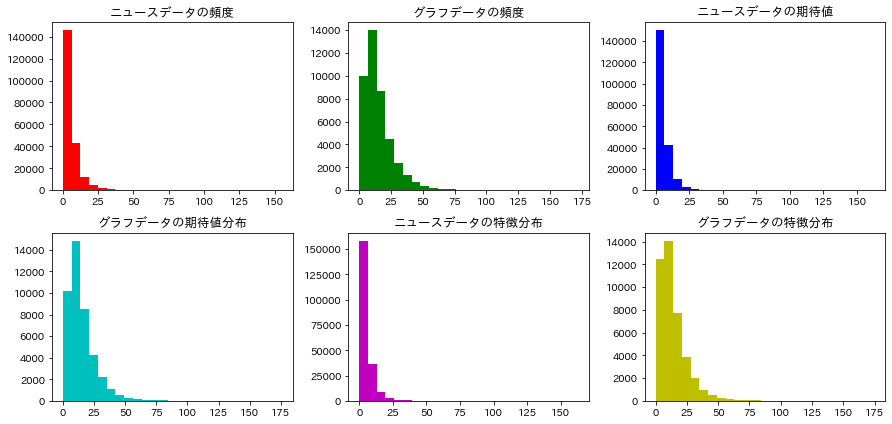

In [9]:
#生成したデータを可視化
dt = [y1, y2, mu1, mu2, uv1, uv2]
fig_range = np.append(np.array([0, 0, 0, 0, 0, 0]), 
                      np.array([np.max(y1), np.max(y2), np.max(mu1), np.max(mu2), np.max(uv1), np.max(uv2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["ニュースデータの頻度", "グラフデータの頻度", "ニュースデータの期待値", "グラフデータの期待値分布",
         "ニュースデータの特徴分布", "グラフデータの特徴分布"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
####Joint Dynamic Poisson Factorizationを推定####
##ハミルトニアンモンテカルロ法を解く関数
#モデルの対数事後分布を計算する関数
def loglike(theta_g, inv_tau1, inv_tau2, mu, y, y_factorial, weeks, trend, k, k_vec, trend_list2):
    
    #ポアソンモデルの対数尤度関数
    LLi = y * np.log(mu) - mu - y_factorial

    #多変量正規分布の対数事前分布
    Prior = [np.repeat(0.0, weeks) for j in range(trend)]
    for j in range(trend):
        er = theta_g[j] - np.vstack((np.repeat(0.0, k), theta_g[j][:weeks-1, ]))
        Prior[j][0] = -1/2 * np.dot(np.dot(er[0, ], inv_tau1), er[0, ])
        Prior[j][1:] = -1/2 * np.dot(np.dot(er[1:, ], inv_tau2[j]) * er[1:, ], k_vec)

    #対数事後分布の和を計算
    Posterior = np.zeros((weeks, trend))
    for i in range(trend):
        for j in range(weeks):
            Posterior[j, i] = np.sum(LLi[trend_list2[i][j]]) + Prior[i][j]
    return Posterior

#対数事後分布の勾配を計算する関数
def dloglike(theta_g, inv_tau1, inv_tau2, uv_neutral, beta_date, beta_item, y, 
             target, trend_list1, trend_list2, week_id, weeks, k, k_vec, N): 
    #モデルの期待値
    index_get = trend_list1[target]
    theta_trend = np.exp(theta_g)[week_id[index_get], ]
    x = uv_neutral[index_get, ] 
    uv = np.repeat(0.0, N)
    uv[index_get, ] = np.dot(x * theta_trend, k_vec)
    mu = beta_date + beta_item + uv

    #対数尤度の勾配ベクトルを定義
    LLd = np.zeros((N, k))
    LLd[index_get, ] = y[index_get, np.newaxis] * (x*theta_trend / mu[index_get, np.newaxis]) - x*theta_trend

    #対数事前分布の勾配ベクトルを定義
    er = theta_g - np.vstack((np.repeat(0.0, k), theta_g[:weeks-1, ]))
    dmvn1 = -np.dot(inv_tau1, er[0, ])
    dmvn2 = -np.dot(inv_tau2[target], er[1:, ].T).T

    #勾配ベクトルの和を定義
    gradient = np.zeros((weeks, k))
    for i in range(weeks):
        if i==0:
            gradient[i, ] = -(np.sum(LLd[trend_list2[target][i], ], axis=0) + dmvn1)
        else:
            gradient[i, ] = -(np.sum(LLd[trend_list2[target][i], ], axis=0) + dmvn2[i-1, ])
    return gradient

#リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, inv_tau1, inv_tau2, uv_neutral1, beta_date, beta_item1, y1, 
                       j, trend_list11, trend_list12, week_id, weeks, k, k_vec, N1) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, inv_tau1, inv_tau2, uv_neutral1, beta_date, beta_item1, y1, 
                        j, trend_list11, trend_list12, week_id, weeks, k, k_vec, N1) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [11]:
##アルゴリズムの設定
#MCMCの設定
R = 1000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
intercept1 = np.repeat(1.0, N1)[:, np.newaxis]
intercept2 = np.repeat(1.0, N2)[:, np.newaxis]

#HMCの設定
alpha_HMC = np.repeat(0.0, k)
Cov_HMC = np.diag(np.repeat(0.1, k))
e = 0.01
L = 3

In [12]:
##パラメータの真値
#事前分布の設定
alpha1 = 0.25; beta1 = 0.25
alpha2 = 0.1; beta2 = 0.1
alpha3 = 5.0; beta3 = 5.0
alpha4 = 0.5; beta4 = 0.5
tau1 = np.diag(np.repeat(0.5, k))
tau2 = [np.diag(np.repeat(0.25, k)) for j in range(trend1)]
inv_tau1 = np.linalg.inv(tau1)
inv_tau2 = [np.linalg.inv(tau2[j]) for j in range(trend1)]
nu = 1.0
V = np.diag(np.repeat(5.0, k))

#モデルパラメータの真値
beta_u = betat_u.copy()
beta_v1 = betat_v1.copy()
beta_v2 = betat_v2.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_e = thetat_e.copy()
theta_g = thetat_g.copy()
omega = omegat.copy()

#パラメータをベクトル化
beta_date = beta_u[date_id]
beta_item1 = beta_v1[item_id1]
beta_item21 = beta_v2[item_id21]
beta_item22 = beta_v2[item_id22]
theta_date = theta_u[date_id, ] 
theta_item1 = theta_v[item_id1, ] 
theta_item21 = theta_v[item_id21, ]
theta_item22 = theta_v[item_id22, ]
theta_element1 = theta_e[element_id1, ]
theta_element21 = theta_e[element_id21, ]
theta_element22 = theta_e[element_id22, ]
theta_trend = [np.exp(theta_g[j])[week_id[trend_list11[j]], ] for j in range(trend1)]

#期待値の真値
uv1 = np.repeat(0.0, N1); uv2 = np.repeat(0.0, N2)
uv_deploy1 = np.zeros((N1, k))
uv_deploy21 = np.zeros((N2, k));  uv_deploy22 = np.zeros((N2, k))
uv_neutral1 = theta_date * theta_item1 * theta_element1
uv_neutral21 = theta_item21 * theta_element21
uv_neutral22 = theta_item22 * theta_element22
for i in range(trend1):
    index = trend_list11[i]
    uv_deploy1[index, ] = uv_neutral1[index, ] * theta_trend[i]
    uv1[index] = np.dot(uv_deploy1[index, ], k_vec)
for i in range(trend2):
    index = trend_list2[i]
    uv_part21 = uv_neutral21[index, ]; uv_part22 = uv_neutral22[index, ]
    uv_deploy21[index, ] = np.dot(uv_part22, omega[i].T) * uv_part21
    uv_deploy22[index, ] = np.dot(uv_part21, omega[i]) * uv_part22
    uv2[index] = np.dot(uv_deploy21[index, ], k_vec)
mu1 = beta_date + beta_item1 + uv1
mu2 = beta_item21 + beta_item22 + uv2
mut1 = mu1.copy(); mut2 = mu2.copy()

In [13]:
##パラメータの初期値
#事前分布の設定
alpha1 = 0.25; beta1 = 0.25
alpha2 = 0.1; beta2 = 0.1
alpha3 = 1.0; beta3 = 1.0
alpha4 = 0.5; beta4 = 0.5
tau1 = np.diag(np.repeat(0.5, k))
tau2 = [np.diag(np.repeat(0.25, k)) for j in range(trend1)]
inv_tau1 = np.linalg.inv(tau1)
inv_tau2 = [np.linalg.inv(tau2[j]) for j in range(trend1)]
nu = 1.0
V = np.diag(np.repeat(5.0, k))

#モデルパラメータの初期値
beta_u = np.random.gamma(0.25, 1/1.0, days)
beta_v1 = np.random.gamma(0.25, 1/1.0, item+1)
beta_v2 = np.random.gamma(0.3, 1/1.0, item+1)
theta_u = np.random.gamma(0.5, 1/1.0, k*days).reshape(days, k)
theta_v = np.vstack((np.random.gamma(0.5, 1/1.0, k*item).reshape(item, k), np.repeat(1.0, k)))
theta_e = np.vstack((np.exp(np.random.normal(0, 0.1, element*k).reshape(element, k)), np.repeat(1.0, k)))
theta_g = [np.random.multivariate_normal(np.repeat(0.0, k), np.diag(np.repeat(0.1, k)), weeks) for j in range(trend1)]
omega = [np.random.gamma(0.25, 1/0.75, k*k).reshape(k, k) for j in range(trend2)]

#パラメータをベクトル化
beta_date = beta_u[date_id]
beta_item1 = beta_v1[item_id1]
beta_item21 = beta_v2[item_id21]
beta_item22 = beta_v2[item_id22]
theta_date = theta_u[date_id, ] 
theta_item1 = theta_v[item_id1, ] 
theta_item21 = theta_v[item_id21, ]
theta_item22 = theta_v[item_id22, ]
theta_element1 = theta_e[element_id1, ]
theta_element21 = theta_e[element_id21, ]
theta_element22 = theta_e[element_id22, ]
theta_trend = [np.exp(theta_g[j])[week_id[trend_list11[j]], ] for j in range(trend1)]

#期待値の初期値
uv1 = np.repeat(0.0, N1); uv2 = np.repeat(0.0, N2)
uv_deploy1 = np.zeros((N1, k)); uv_deploy2 = np.zeros((N2, k))
uv_neutral1 = theta_date * theta_item1 * theta_element1
uv_neutral21 = theta_item21 * theta_element21
uv_neutral22 = theta_item22 * theta_element22
for i in range(trend1):
    index = trend_list11[i]
    uv_deploy1[index, ] = uv_neutral1[index, ] * theta_trend[i]
    uv1[index] = np.dot(uv_deploy1[index, ], k_vec)
for i in range(trend2):
    index = trend_list2[i]
    uv_part21 = uv_neutral21[index, ]; uv_part22 = uv_neutral22[index, ]
    uv_deploy21[index, ] = np.dot(uv_part22, omega[i].T) * uv_part21
    uv_deploy22[index, ] = np.dot(uv_part21, omega[i]) * uv_part22
    uv2[index] = np.dot(uv_deploy21[index, ], k_vec)
mu1 = beta_date + beta_item1 + uv1
mu2 = beta_item21 + beta_item22 + uv2

In [14]:
#パラメータの格納用配列
BETA_U = np.zeros((int(R/keep), days))
BETA_V1 = np.zeros((int(R/keep), item+1))
BETA_V2 = np.zeros((int(R/keep), item+1))
THETA_U = np.zeros((days, k, int(R/keep)))
THETA_V = np.zeros((item+1, k, int(R/keep)))
THETA_E = np.zeros((element+1, k, int(R/keep)))
THETA_G = [i for i in range(int(R/keep))]
OMEGA = [i for i in range(int(R/keep))]
TAU = [i for i in range(int(R/keep))]

In [15]:
##対数尤度の基準値
#1パラメータモデルでの対数尤度
LLst1 = np.sum(scipy.stats.poisson.logpmf(y1, np.mean(y1)))
LLst2 = np.sum(scipy.stats.poisson.logpmf(y2, np.mean(y2)))
LLst = LLst1 + LLst2
print(np.round([LLst1, LLst2], 1))

#真値での対数尤度
LLbest1 = np.sum(scipy.stats.poisson.logpmf(y1, mut1))
LLbest2 = np.sum(scipy.stats.poisson.logpmf(y2, mut2))
LLbest = LLbest1 + LLbest2
print(np.round([LLbest1, LLbest2], 1))

[-852190.3 -263227.2]
[-437438.6 -111530.8]


In [16]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):

    ##dateベクトルをサンプリング
    #補助変数lambdaを更新
    date_deploy = np.hstack((beta_date[:, np.newaxis], uv_deploy1))
    Lambda = date_deploy / mu1[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y1[:, np.newaxis]
    lambda_h = np.hstack((intercept1, uv_deploy1 / theta_date))
    w1 = np.repeat(0.0, days); w2 = np.repeat(0.0, days)
    W1 = np.zeros((days, k)); W2 = np.zeros((days, k))
    for i in range(days):
        w1[i] = np.sum(lambda_y[date_list[i], 0]) + alpha1
        w2[i] = np.sum(lambda_h[date_list[i], 0]) + beta1
        W1[i, ] = np.sum(lambda_y[date_list[i], 1:], axis=0) + alpha1
        W2[i, ] = np.sum(lambda_h[date_list[i], 1:], axis=0) + beta1

    #ガンマ分布からパラメータをサンプリング
    beta_u = np.random.gamma(w1, 1/w2, days)
    theta_u = np.random.gamma(W1, 1/W2)
    beta_date = beta_u[date_id]
    theta_date = theta_u[date_id, ] 

    #期待値の更新
    uv_neutral1 = theta_date * theta_item1 * theta_element1
    for i in range(trend1):
        index = trend_list11[i]
        uv_deploy1[index, ] = uv_neutral1[index, ] * theta_trend[i]
        uv1[index, ] = np.dot(uv_deploy1[index, ], k_vec)
    mu1 = beta_date + beta_item1 + uv1


    ##itemベクトルをサンプリング
    #補助変数lambdaを更新
    item_deploy1 = np.hstack((beta_item1[:, np.newaxis], uv_deploy1))
    item_deploy2 = np.hstack((beta_item21[:, np.newaxis], beta_item22[:, np.newaxis]))
    Lambda1 = item_deploy1 / mu1[:, np.newaxis]
    Lambda21 = uv_deploy21 / mu2[:, np.newaxis]
    Lambda22 = uv_deploy22 / mu2[:, np.newaxis]
    Lambda23 = item_deploy2 / mu2[:, np.newaxis]

    #重み付き変数を定義
    lambda_y1 = Lambda1 * y1[:, np.newaxis]
    lambda_y21 = Lambda21 * y2[:, np.newaxis]
    lambda_y22 = Lambda22 * y2[:, np.newaxis]
    lambda_y23 = Lambda23 * y2[:, np.newaxis]
    lambda_h1 = np.hstack((intercept1, uv_deploy1 / theta_item1))
    lambda_h21 = uv_deploy21 / theta_item21
    lambda_h22 = uv_deploy22 / theta_item22


    #itemごとの事後分布のパラメータを定義
    w11 = np.repeat(0.0, item+1); w12 = np.repeat(0.0, item+1)
    w21 = np.repeat(0.0, item+1); w22 = np.repeat(0.0, item+1)
    W1 = np.zeros((item, k)); W2 = np.zeros((item, k))
    for i in range(item+1):
        w11[i] = np.sum(lambda_y1[item_list1[i], 0]) + alpha2
        w12[i] = np.sum(lambda_h1[item_list1[i], 0]) + beta2
        w21[i] = np.sum(lambda_y23[item_list21[i], 0]) + np.sum(lambda_y23[item_list22[i], 1]) + alpha2
        w22[i] = item_n21[i] + item_n22[i] + beta2
        if i < item:
            W11 = np.sum(lambda_y1[item_list1[i], 1:], axis=0) 
            W12 = np.sum(lambda_h1[item_list1[i], 1:], axis=0)
            W21 = np.sum(lambda_y21[item_list21[i], ], axis=0) + np.sum(lambda_y22[item_list22[i], ], axis=0) 
            W22 = np.sum(lambda_h21[item_list21[i], ], axis=0) + np.sum(lambda_h22[item_list22[i], ], axis=0) 
            W1[i, ] = W11 + W21 + alpha2
            W2[i, ] = W12 + W22 + beta2

    #ガンマ分布より事後分布をサンプリング
    beta_v1 = np.random.gamma(w11, 1/w12, item+1)
    beta_v2 = np.random.gamma(w21, 1/w22, item+1)
    theta_v = np.vstack((np.random.gamma(W1, 1/W2), np.repeat(1.0, k)))
    beta_item1 = beta_v1[item_id1]
    beta_item21 = beta_v2[item_id21]
    beta_item22 = beta_v2[item_id22]
    theta_item1 = theta_v[item_id1, ] 
    theta_item21 = theta_v[item_id21, ]
    theta_item22 = theta_v[item_id22, ]

    #期待値の更新
    uv_neutral1 = theta_date * theta_item1 * theta_element1
    uv_neutral21 = theta_item21 * theta_element21
    uv_neutral22 = theta_item22 * theta_element22
    for i in range(trend1):
        index = trend_list11[i]
        uv_deploy1[index, ] = uv_neutral1[index, ] * theta_trend[i]
        uv1[index] = np.dot(uv_deploy1[index, ], k_vec)
    for i in range(trend2):
        index = trend_list2[i]
        uv_part21 = uv_neutral21[index, ]; uv_part22 = uv_neutral22[index, ]
        uv_deploy21[index, ] = np.dot(uv_part22, omega[i].T) * uv_part21
        uv_deploy22[index, ] = np.dot(uv_part21, omega[i]) * uv_part22
        uv2[index] = np.dot(uv_deploy21[index, ], k_vec)
    mu1 = beta_date + beta_item1 + uv1
    mu2 = beta_item21 + beta_item22 + uv2


    ##elementベクトルをサンプリング
    #補助変数lambdaを更新
    Lambda1 = uv_deploy1 / mu1[:, np.newaxis]
    Lambda21 = uv_deploy21 / mu2[:, np.newaxis]
    Lambda22 = uv_deploy22 / mu2[:, np.newaxis]

    #重み付き変数を定義
    lambda_y1 = Lambda1 * y1[:, np.newaxis]
    lambda_y21 = Lambda21 * y2[:, np.newaxis]
    lambda_y22 = Lambda22 * y2[:, np.newaxis]
    lambda_h1 = uv_deploy1 / theta_element1
    lambda_h21 = uv_deploy21 / theta_element21
    lambda_h22 = uv_deploy22 / theta_element22

    #elementごとの事後分布のパラメータを定義
    W1 = np.zeros((element, k)); W2 = np.zeros((element, k))
    for i in range(element):
        W11 = np.sum(lambda_y1[element_list1[i], ], axis=0) 
        W12 = np.sum(lambda_h1[element_list1[i], ], axis=0)
        W21 = np.sum(lambda_y21[element_list21[i], ], axis=0) + np.sum(lambda_y22[element_list22[i], ], axis=0) 
        W22 = np.sum(lambda_h21[element_list21[i], ], axis=0) + np.sum(lambda_h22[element_list22[i], ], axis=0) 
        W1[i, ] = W11 + W21 + alpha3
        W2[i, ] = W12 + W22 + beta3

    #ガンマ分布より事後分布をサンプリング
    theta_e = np.vstack((np.random.gamma(W1, 1/W2), np.repeat(1.0, k)))
    theta_element1 = theta_e[element_id1, ]
    theta_element21 = theta_e[element_id21, ]
    theta_element22 = theta_e[element_id22, ]

    #期待値の更新
    uv_neutral1 = theta_date * theta_item1 * theta_element1
    uv_neutral21 = theta_item21 * theta_element21
    uv_neutral22 = theta_item22 * theta_element22
    for i in range(trend1):
        index = trend_list11[i]
        uv_deploy1[index, ] = uv_neutral1[index, ] * theta_trend[i]
        uv1[index] = np.dot(uv_deploy1[index, ], k_vec)
    for i in range(trend2):
        index = trend_list2[i]
        uv_part21 = uv_neutral21[index, ]; uv_part22 = uv_neutral22[index, ]
        uv_deploy21[index, ] = np.dot(uv_part22, omega[i].T) * uv_part21
        uv_deploy22[index, ] = np.dot(uv_part21, omega[i]) * uv_part22
        uv2[index] = np.dot(uv_deploy21[index, ], k_vec)
    mu1 = beta_date + beta_item1 + uv1
    mu2 = beta_item21 + beta_item22 + uv2


    ##trendベクトルをサンプリング
    #サンプリングされたパラメータの格納用配列
    accept_prob = np.zeros((weeks, trend1))
    thetad = [j for j in range(trend1)]
    thetan = [j for j in range(trend1)]
    rold = [j for j in range(trend1)]
    rnew = [j for j in range(trend1)]

    for j in range(trend1):
        #HMCの新しいパラメータを生成
        rold[j] = np.random.multivariate_normal(alpha_HMC, Cov_HMC, weeks)
        thetad[j] = theta_g[j]

        #リープフロッグ法による1ステップ移動
        res = leapfrog(rold[j], thetad[j], dloglike, e, L)
        rnew[j] = res[0]
        thetan[j] = res[1]

    #新しいパラメータでの対数事後分布を更新
    theta_old = theta_trend.copy()
    theta_new = [np.exp(thetan[j])[week_id[trend_list11[j]], ] for j in range(trend1)]
    mu_old = mu1.copy()
    uv = np.repeat(0.0, N1)
    for i in range(trend1):
        uv[trend_list11[i], ] = np.dot(uv_neutral1[trend_list11[i] , ] * theta_new[i], k_vec)
    mu_new = beta_date + beta_item1 + uv
    Posterior_old = loglike(thetad, inv_tau1, inv_tau2, mu_old, y1, y_factorial1, weeks, trend1, k, k_vec, trend_list12)
    Posterior_new = loglike(thetan, inv_tau1, inv_tau2, mu_new, y1, y_factorial1, weeks, trend1, k, k_vec, trend_list12)

    #移動前と移動後のハミルトニアン
    for j in range(trend1):
        rev_old = np.dot(np.power(rold[j], 2), k_vec) / 2 
        rev_new = np.dot(np.power(rnew[j], 2), k_vec) / 2
        Hold = -Posterior_old[:, j] + rev_old
        Hnew = -Posterior_new[:, j] + rev_new

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, weeks)
        gamma = np.min(np.hstack((np.repeat(1, weeks)[:, np.newaxis], np.exp(Hold - Hnew)[:, np.newaxis])), axis=1)
        accept_prob[:, j] = gamma.copy()

        #gammaの値に基づき新しいユーザーパラメータを採択
        flag = np.array(gamma > rand, dtype="int")[:, np.newaxis]
        theta_g[j] = flag*thetan[j] + (1-flag)*thetad[j]

    #期待値を更新
    theta_trend = [np.exp(theta_g[j])[week_id[trend_list11[j]], ] for j in range(trend1)]
    for i in range(trend1):
        index = trend_list11[i]
        uv_deploy1[index, ] = uv_neutral1[index, ] * theta_trend[i]
        uv1[index] = np.dot(uv_deploy1[index, ], k_vec)
    mu1 = beta_date + beta_item1 + uv1


    ##omegaをサンプリング
    #補助変数lambdaを更新
    for i in range(trend2):
        uv_block = np.zeros((k, k))
        index = trend_list2[i]
        for j in range(k):
            uv_block[j, ] = np.sum(uv_neutral21[index, j][:, np.newaxis] * uv_neutral22[index, ] , axis=0)
        omega_block = omega[i] * uv_block
        Lambda = omega_block / np.sum(mu2[index])   #補助変数

        #ガンマ分布からパラメータをサンプリング
        W1 = Lambda * np.sum(y2[index]) + alpha4
        W2 = uv_block + beta4
        omega[i] = np.random.gamma(W1, 1/W2)

        
    #期待値の更新
    for i in range(trend2):
        index = trend_list2[i]
        uv_part21 = uv_neutral21[index, ]; uv_part22 = uv_neutral22[index, ]
        uv_deploy21[index, ] = np.dot(uv_part22, omega[i].T) * uv_part21
        uv_deploy22[index, ] = np.dot(uv_part21, omega[i]) * uv_part22
        uv2[index] = np.dot(uv_deploy21[index, ], k_vec)
    mu2 = beta_item21 + beta_item22 + uv2
    

    ##システム分散をサンプリング
    for j in range(trend1):
        #事後分布のパラメータ
        er = theta_g[j][1:, ] - theta_g[j][:weeks-1, ]
        IW_R = np.dot(er.T, er) + V
        Sn = weeks - 1 + nu

        #逆ウィシャート分布からパラメータをサンプリング
        tau2[j] = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
        inv_tau2[j] = np.linalg.inv(tau2[j])


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        BETA_U[mkeep, ] = beta_u
        BETA_V1[mkeep, ] = beta_v1
        BETA_V2[mkeep, ] = beta_v2
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_E[:, :, mkeep] = theta_e
        THETA_G[mkeep] = theta_g.copy()
        OMEGA[mkeep] = omega.copy()
        TAU[mkeep] = tau2

    #対数尤度の更新とサンプリング結果の表示
    if rp%disp==0:
        #対数尤度を更新
        LL1 = np.sum(scipy.stats.poisson.logpmf(y1, mu1))
        LL2 = np.sum(scipy.stats.poisson.logpmf(y2, mu2))
        LL = LL1 + LL2
        
        #サンプリング結果の表示
        print(rp)
        print(np.round(np.mean(accept_prob, axis=0), 3))
        print(np.round([LL1, LL2, LLst1, LLst2, LLbest1, LLbest2], 1))
        print(np.round([LL, LLst, LLbest], 1))

0
[0.986 0.989 0.985 0.987 0.989]
[-704542.7 -189927.5 -852190.3 -263227.2 -437438.6 -111530.8]
[ -894470.3 -1115417.5  -548969.4]
10
[0.971 0.973 0.969 0.978 0.981]
[-596927.3 -148609.2 -852190.3 -263227.2 -437438.6 -111530.8]
[ -745536.4 -1115417.5  -548969.4]
20
[0.972 0.978 0.975 0.977 0.975]
[-569474.6 -142851.8 -852190.3 -263227.2 -437438.6 -111530.8]
[ -712326.3 -1115417.5  -548969.4]
30
[0.968 0.969 0.976 0.978 0.976]
[-550036.4 -140595.4 -852190.3 -263227.2 -437438.6 -111530.8]
[ -690631.8 -1115417.5  -548969.4]
40
[0.975 0.974 0.972 0.973 0.971]
[-536378.7 -139439.1 -852190.3 -263227.2 -437438.6 -111530.8]
[ -675817.8 -1115417.5  -548969.4]
50
[0.975 0.972 0.978 0.973 0.975]
[-526381.9 -138413.7 -852190.3 -263227.2 -437438.6 -111530.8]
[ -664795.6 -1115417.5  -548969.4]
60
[0.971 0.975 0.975 0.973 0.972]
[-518914.3 -137694.3 -852190.3 -263227.2 -437438.6 -111530.8]
[ -656608.6 -1115417.5  -548969.4]
70
[0.97  0.973 0.975 0.97  0.976]
[-512493.9 -137089.7 -852190.3 -263227.2 -

620
[0.959 0.961 0.955 0.951 0.957]
[-443398.6 -132713.3 -852190.3 -263227.2 -437438.6 -111530.8]
[ -576111.9 -1115417.5  -548969.4]
630
[0.96  0.965 0.958 0.949 0.953]
[-443384.6 -132719.3 -852190.3 -263227.2 -437438.6 -111530.8]
[ -576103.9 -1115417.5  -548969.4]
640
[0.956 0.964 0.955 0.958 0.949]
[-443247.  -132560.6 -852190.3 -263227.2 -437438.6 -111530.8]
[ -575807.6 -1115417.5  -548969.4]
650
[0.961 0.963 0.953 0.957 0.95 ]
[-443206.3 -132572.2 -852190.3 -263227.2 -437438.6 -111530.8]
[ -575778.5 -1115417.5  -548969.4]
660
[0.962 0.959 0.954 0.957 0.95 ]
[-443085.2 -132639.9 -852190.3 -263227.2 -437438.6 -111530.8]
[ -575725.1 -1115417.5  -548969.4]
670
[0.959 0.965 0.955 0.958 0.96 ]
[-442992.5 -132544.  -852190.3 -263227.2 -437438.6 -111530.8]
[ -575536.5 -1115417.5  -548969.4]
680
[0.959 0.964 0.954 0.96  0.958]
[-442905.4 -132640.3 -852190.3 -263227.2 -437438.6 -111530.8]
[ -575545.7 -1115417.5  -548969.4]
690
[0.951 0.962 0.959 0.955 0.954]
[-442957.5 -132513.3 -852190.3 -2